In [4]:
# Workaround to use src modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [78]:
# Library imports
import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.color import rgb2lab
from scipy.stats import mode

# Functions Imports
from src.utils import image_to_grayscale, image_minmax_norm
from src.quantization import image_bitshift
from src.segmentation import threshold_segmentation, otsu_segmentation
from src.visualizations import visualize_bitshift_images

## Objetivo

Explorar técnicas de extração de paleta de cores para redução da quantidade de cores necessárias na imagem final para um N pré-selecionado.

## 1º Método - Utilizando Kmeans clustering

O primeiro método utiliza o algoritmo de aprendizado não supervisionado para gerar uma paleta de K cores que melhor representam o conjunto de cores da imagem. P/ isso utilizamos o algoritmo nas cores em diferentes espaços para verificar em qual deles as cores são melhores separáveis (RGB, LAB, HSV) além de aplicar métodos de correção gamma. 

In [135]:
from sklearn.cluster import KMeans
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter

def palette_kmeans(image, N):
    # Pré-proccess: precisamos mudar a imagem de (N,N,3) p/ (N²,3)
    image_inline =  image.reshape(-1,3)
    
    # Training the model
    kmeans = KMeans(n_clusters=N, max_iter=300)
    kmeans.fit(image_inline)
    
    # Return Collor pallete (np.array)
    palette = kmeans.cluster_centers_
    
    # Reconstruct the image with the N colors
    image_labels = kmeans.predict(image_inline)
    image_labels = image_labels.reshape((image.shape[0], image.shape[1]))
    image_output = np.zeros(image.shape)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_output[i,j,:] = palette[image_labels[i,j]]
    
    return palette, image_output, image_labels, kmeans

def labels_to_edges(labels):
    # Pre-proccess: add symetric pad to avoid corners bugs
    edge_map = np.zeros(labels.shape, dtype=np.int)
    labels   = np.pad(labels, 1, mode="symmetric")
    
    # Apply Laplacian filter to detect if any 8-neighboor is diff
    # not edge -> 0 (black)
    # edge     -> 1 (white)
    for i in range(1,labels.shape[0]-1):
        for j in range(1,labels.shape[1]-1):
            same_color = np.sum(labels[i-1:i+2,j-1:j+2] == labels[i,j]) != 9
            # print(i,j,same_color)
            # print(labels[i-1:i+2,j-1:j+2])
            edge_map[i-1, j-1] = same_color * 1
    
    return edge_map

In [136]:
def plot_pallete(palette, shape):
    plt.figure(figsize=(12,1))
    for i in range(palette.shape[0]):
        plt.subplot(shape[0],shape[1],i+1)
        plt.axis("off")
        plt.imshow(np.ones((3,3,3), dtype=np.int)*palette[i].astype(np.int))
        
def plot_imagegrid(images, shape, figsize):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(shape[0],shape[1],i+1)
        plt.imshow(images[i].astype(np.int), cmap="gray")

In [164]:
def exploratory_pipeline(image_path, N=8, palette_shape=(2,8), save_path=None):
    
    # Obs: Em imagens png ignorar o alpha usando image[:,:,:3]
    image = imageio.imread(image_path).astype(np.uint8)
    
    # Pipeline 1 - No Image Pre-proccess 
    # - Quantization to pallete with N  colors
    # - Edge detection based on image labes
    palette, image_kmean, labels, model = palette_kmeans(image[:,:,:3], N) # Obs: pode levar até 1 min :P
    edges = labels_to_edges(labels)
    
    plot_pallete(palette, palette_shape)
    plot_imagegrid([image, image_kmean, edges], shape=(1,3), figsize=(40,40))
    
    # Pipeline 2 - Image enhance before quantize
    image_smooth = np.zeros(image[:,:,:3].shape)
    for c in range(3):
        image_smooth[:,:,c] = gaussian_filter(image[:,:,c], sigma=2, mode='nearest')
    palette, image_kmean, labels, model = palette_kmeans(image_smooth[:,:,:3], N) # Obs: pode levar até 1 min :P
    edges = labels_to_edges(labels)
    
    plot_pallete(palette, palette_shape)
    plot_imagegrid([image, image_kmean, edges], shape=(1,3), figsize=(40,40))
    
    if save_path is not None:
        imageio.imwrite(save_path, image_kmean)

Lossy conversion from float64 to uint8. Range [23.31319772194486, 230.57433802780207]. Convert image to uint8 prior to saving to suppress this warning.


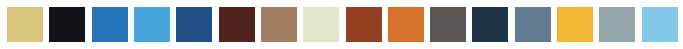

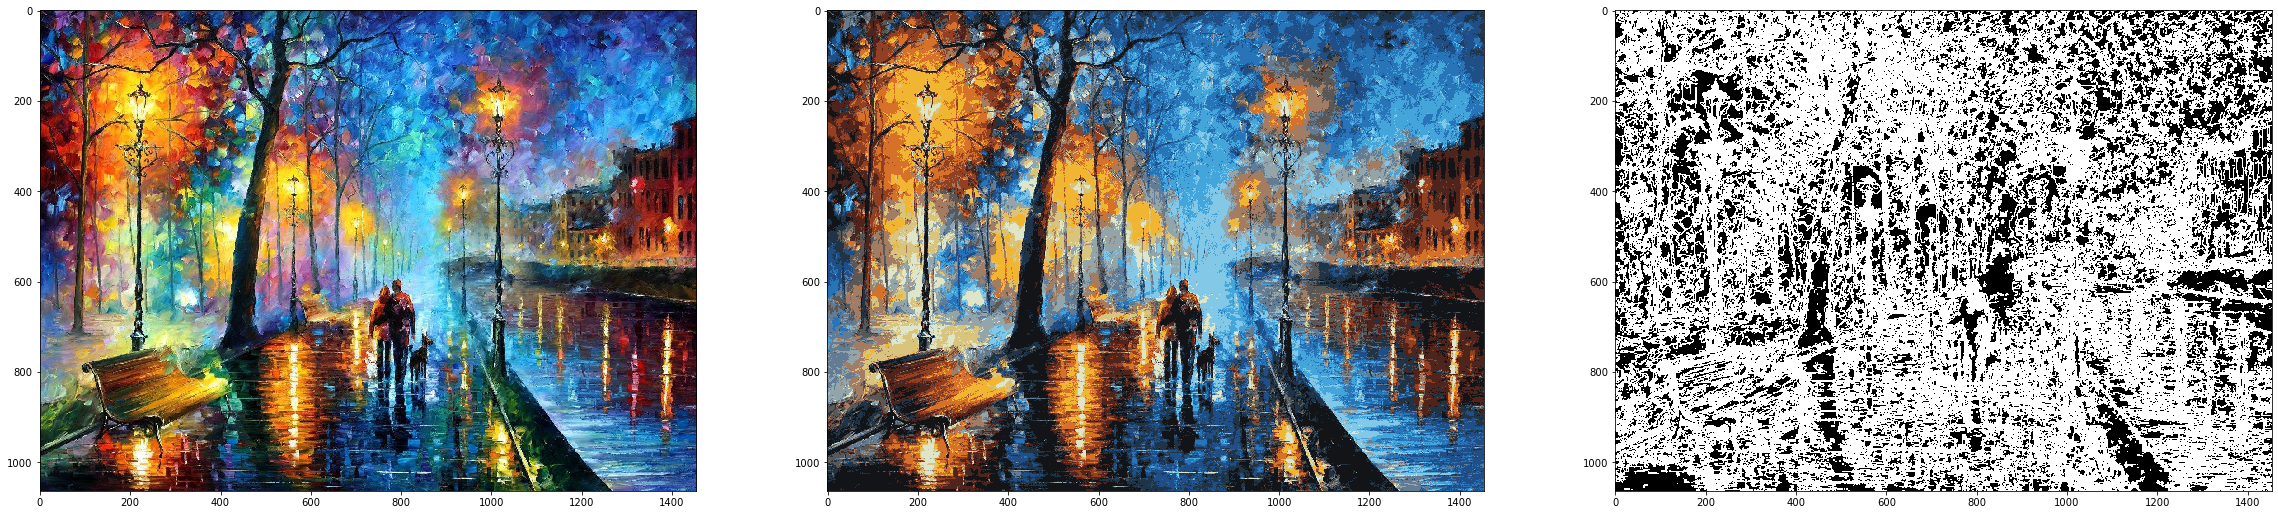

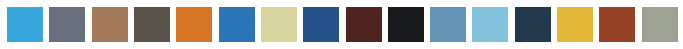

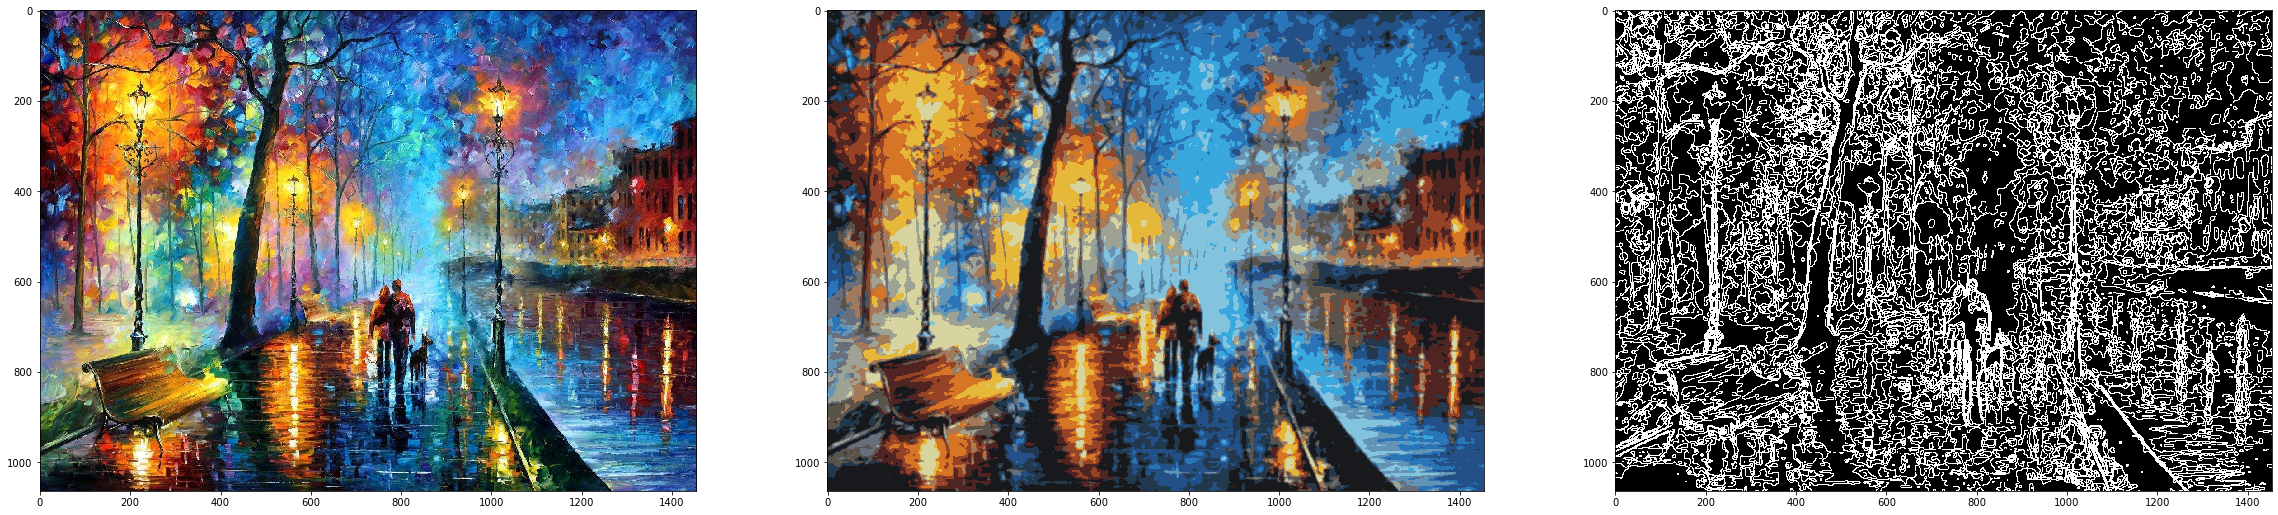

In [167]:
exploratory_pipeline('../images/raw/painting_afremov.jpg', N=16, palette_shape=(1,16), save_path=None)

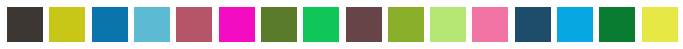

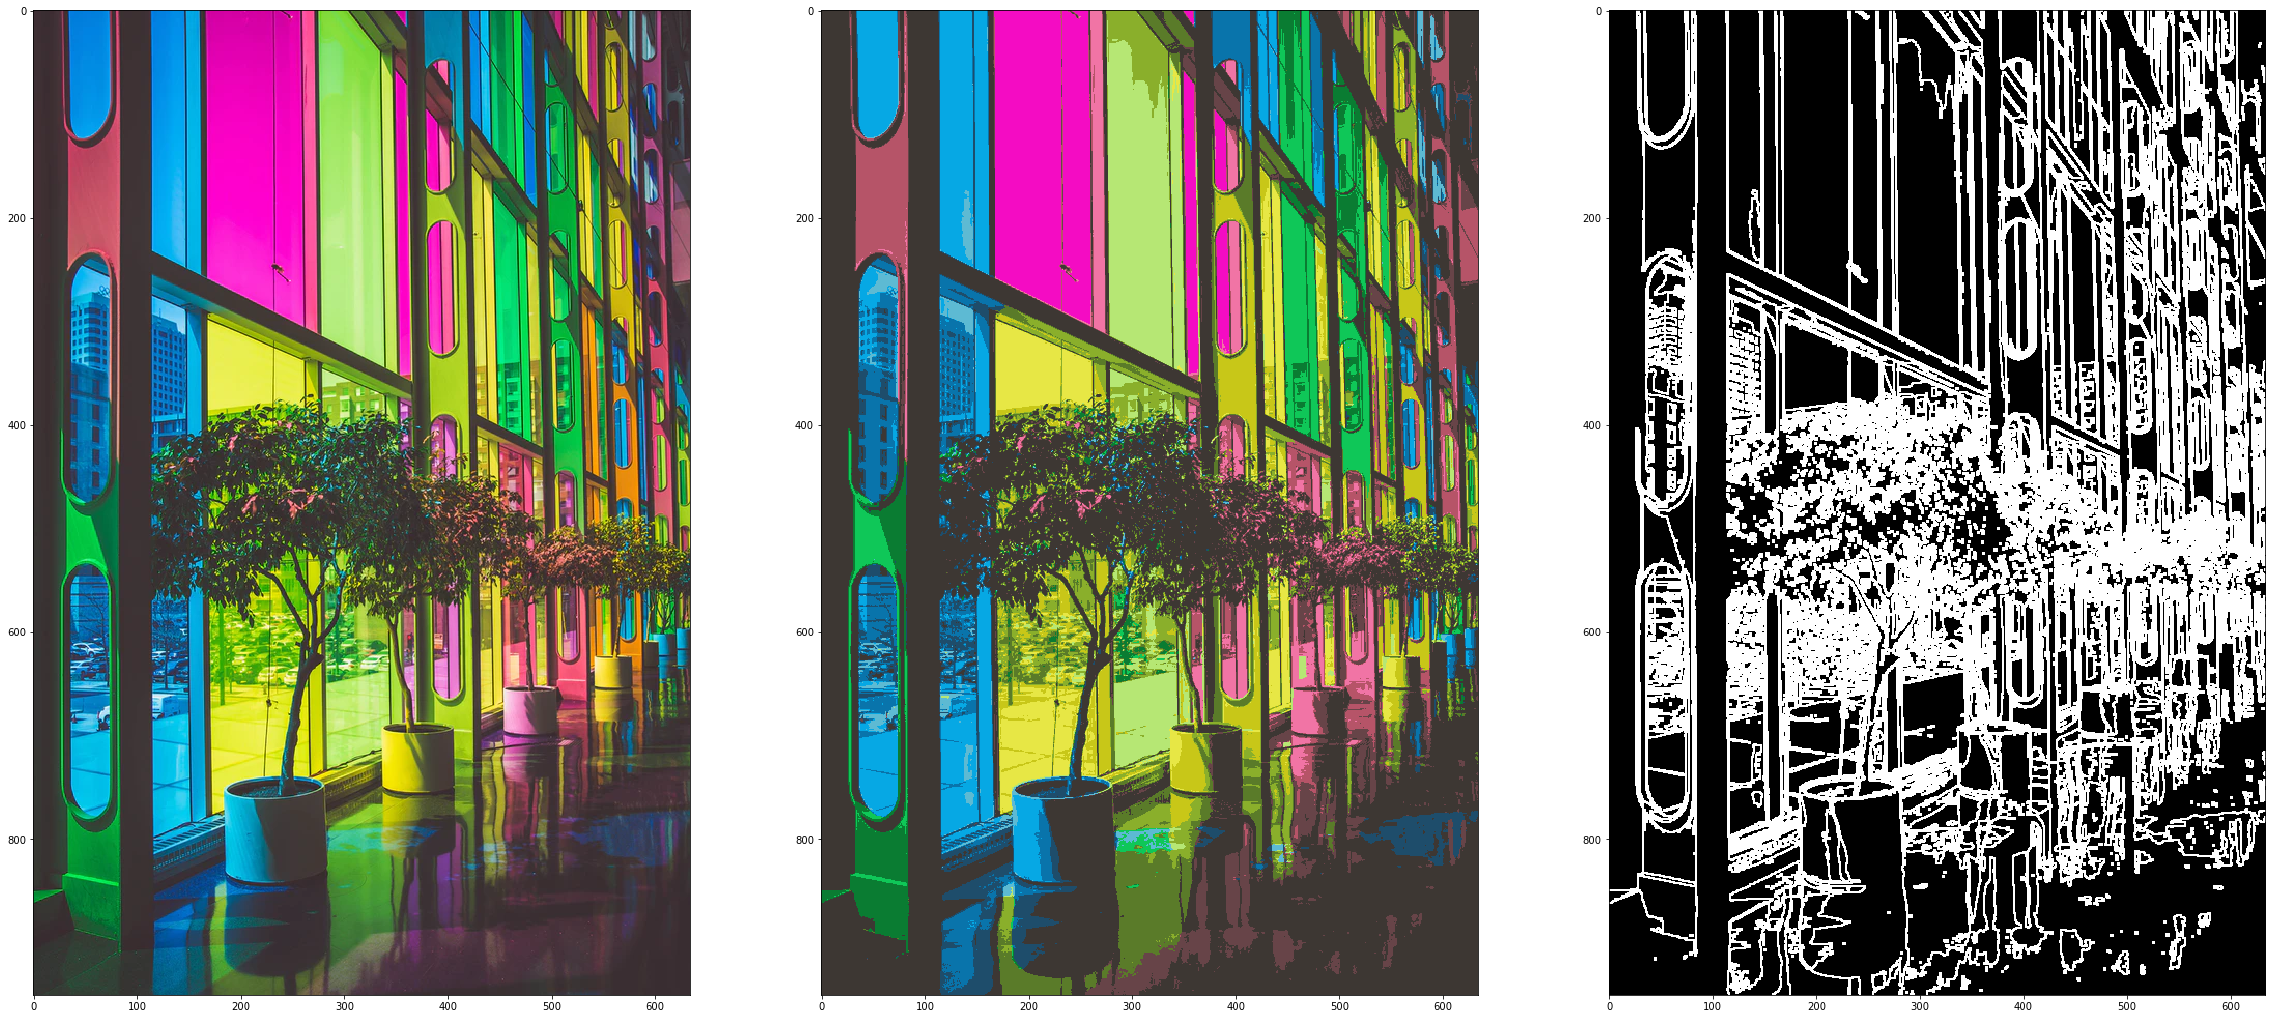

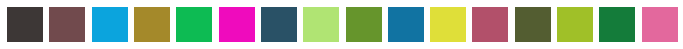

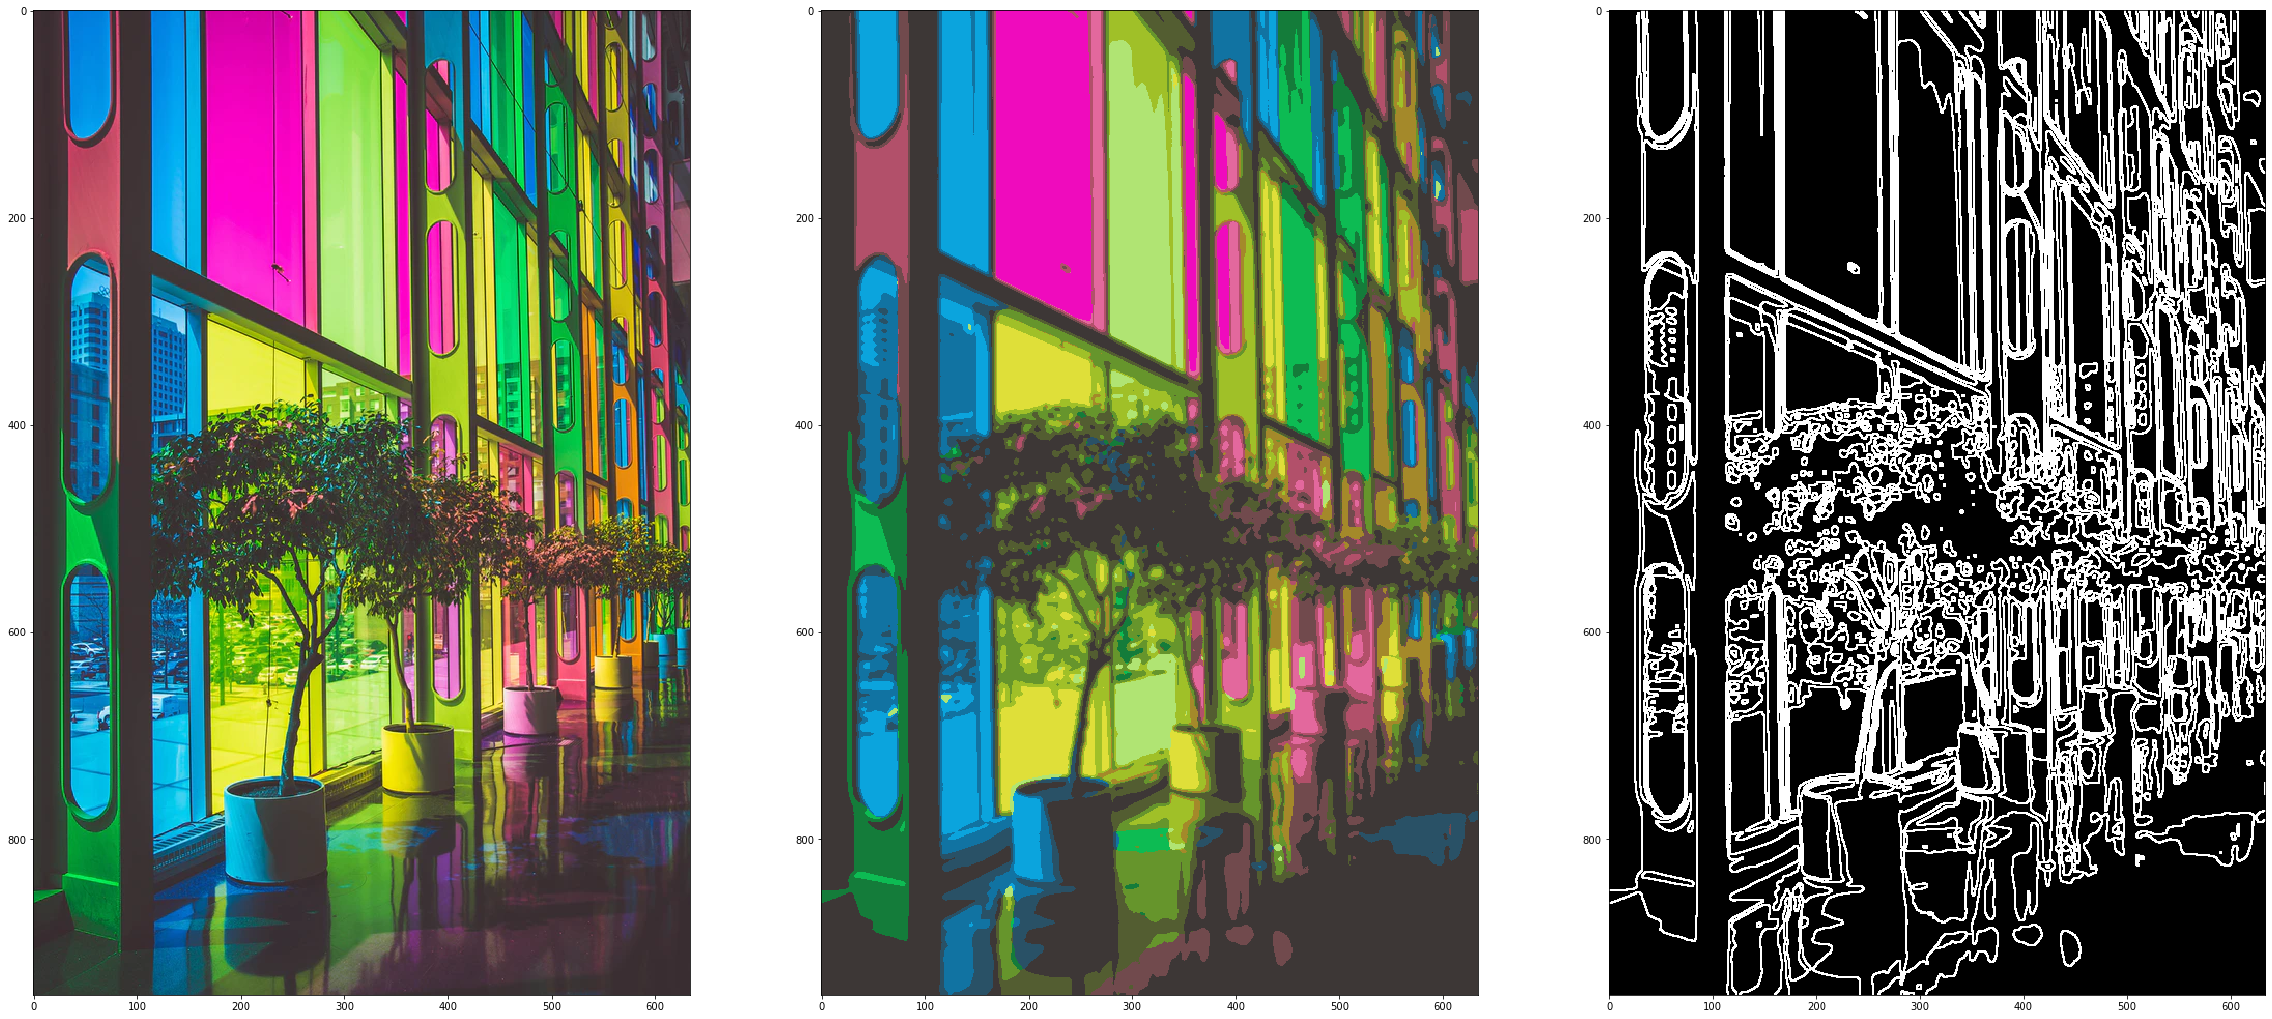

In [168]:
exploratory_pipeline('../images/raw/scenario_rainbow.png', N=16, palette_shape=(1,16), save_path=None)